In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import davies_bouldin_score, silhouette_score

df = pd.read_csv('data/wein.csv')
df.head()

,Alkohol,Apfelsaeure,Asche,Aschen_Alkanitaet,Magnesium,Alle_Phenole,Flavanoide,Nichtflavanoide_Phenole,Proanthocyanide,Farbintensitaet,Farbwert,Proteinwert,Prolinwert
0,14.23,1.71,2.43,15.06.,127,02.08.,03.06.,0.28,2.29,5.64,01.04.,3.92,1065
1,13.02.,1.78,2.14,11.02.,100,2.65,2.76,0.26,1.28,4.38,01.05.,03.04.,1050
2,13.16,2.36,2.67,18.06.,101,02.08.,3.24,0.30,2.81,5.68,01.03.,3.17,1185
3,14.37,1.95,02.05.,16.08.,113,3.85,3.49,0.24,2.18,07.08.,0.86,3.45,1480
4,13.24,2.59,2.87,21,118,02.08.,2.69,0.39,1.82,4.32,01.04.,2.93,735


In [23]:
df.shape

(178, 13)

# Data Preparation

Some values seem to be formatted like dates in that the left side has an additional 0 and the right side ends with a dot. Strip the left and right sides and convert the strings to float since all cells are number values.

In [24]:
df = df.applymap(lambda x: x.lstrip('0').rstrip('.') if isinstance(x, str) else x)
df = df.applymap(lambda x: float(x))
df.head()

,Alkohol,Apfelsaeure,Asche,Aschen_Alkanitaet,Magnesium,Alle_Phenole,Flavanoide,Nichtflavanoide_Phenole,Proanthocyanide,Farbintensitaet,Farbwert,Proteinwert,Prolinwert
0,14.23,1.71,2.43,15.06,127.0,2.08,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.02,1.78,2.14,11.02,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.04,1050.0
2,13.16,2.36,2.67,18.06,101.0,2.08,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.05,16.08,113.0,3.85,3.49,0.24,2.18,7.08,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.00,118.0,2.08,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [25]:
df.isna().any()

Alkohol                    False
Apfelsaeure                False
Asche                      False
Aschen_Alkanitaet          False
Magnesium                  False
Alle_Phenole               False
Flavanoide                 False
Nichtflavanoide_Phenole    False
Proanthocyanide            False
Farbintensitaet            False
Farbwert                   False
Proteinwert                False
Prolinwert                 False
dtype: bool

## Outliers

Use z-score to check for outliers in the data that might confuse the regression model

In [26]:
for col in df.columns:
    data = np.array(df[col])
     
    mean = np.mean(data)
    std = np.std(data)
     
    threshold = 3
    outliers = []
    for x in data:
        z_score = (x - mean) / std
        if abs(z_score) > threshold:
            outliers.append(x)
    print(col)
    print('Mean:', round(mean, 2), '+-', round(std, 2))
    print('Outliers:', outliers, '\n')

Alkohol
Mean: 12.97 +- 0.81
Outliers: [] 

Apfelsaeure
Mean: 2.28 +- 1.1
Outliers: [5.65] 

Asche
Mean: 2.28 +- 0.32
Outliers: [1.07, 1.07, 1.09] 

Aschen_Alkanitaet
Mean: 19.26 +- 3.35
Outliers: [30.0] 

Magnesium
Mean: 99.74 +- 14.24
Outliers: [151.0, 162.0] 

Alle_Phenole
Mean: 2.16 +- 0.66
Outliers: [] 

Flavanoide
Mean: 2.01 +- 1.0
Outliers: [5.08] 

Nichtflavanoide_Phenole
Mean: 0.36 +- 0.12
Outliers: [] 

Proanthocyanide
Mean: 1.57 +- 0.57
Outliers: [3.28, 3.58] 

Farbintensitaet
Mean: 4.82 +- 2.33
Outliers: [13.0] 

Farbwert
Mean: 6.04 +- 67.65
Outliers: [906.0] 

Proteinwert
Mean: 2.58 +- 0.72
Outliers: [] 

Prolinwert
Mean: 746.89 +- 314.02
Outliers: [] 



The "Farbwert" column seems to have a noteworthy outlier, this is especially noticeable when scatter plotting against "Alkohol" which we will be doing later on:

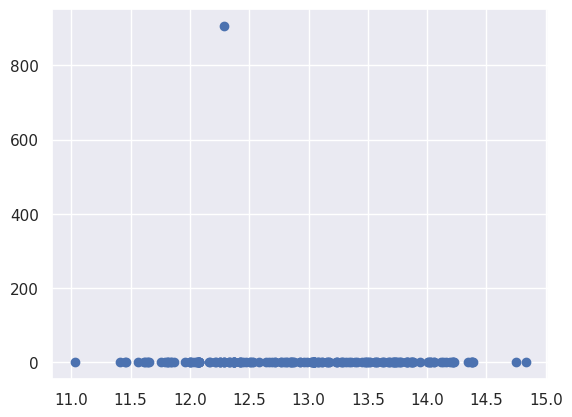

In [27]:
plt.scatter(df['Alkohol'], df['Farbwert'])
plt.show()

Let's remove the row with this outlier as the reported value of 906 seems to be false (formatting error or measuring error):

In [28]:
farbwert = df['Farbwert']
mask = abs((farbwert - np.mean(farbwert)) / np.std(farbwert)) > threshold
rows_to_drop = df[mask].index
df.drop(rows_to_drop, inplace=True)
df.shape

(177, 13)

## Training the models

Now we train the models on pairs of attributes and plot the pairwise predictions (this amounts to $ \frac{k(k-1)}{2} $ plots since we only want the bottom corner of the matrix)

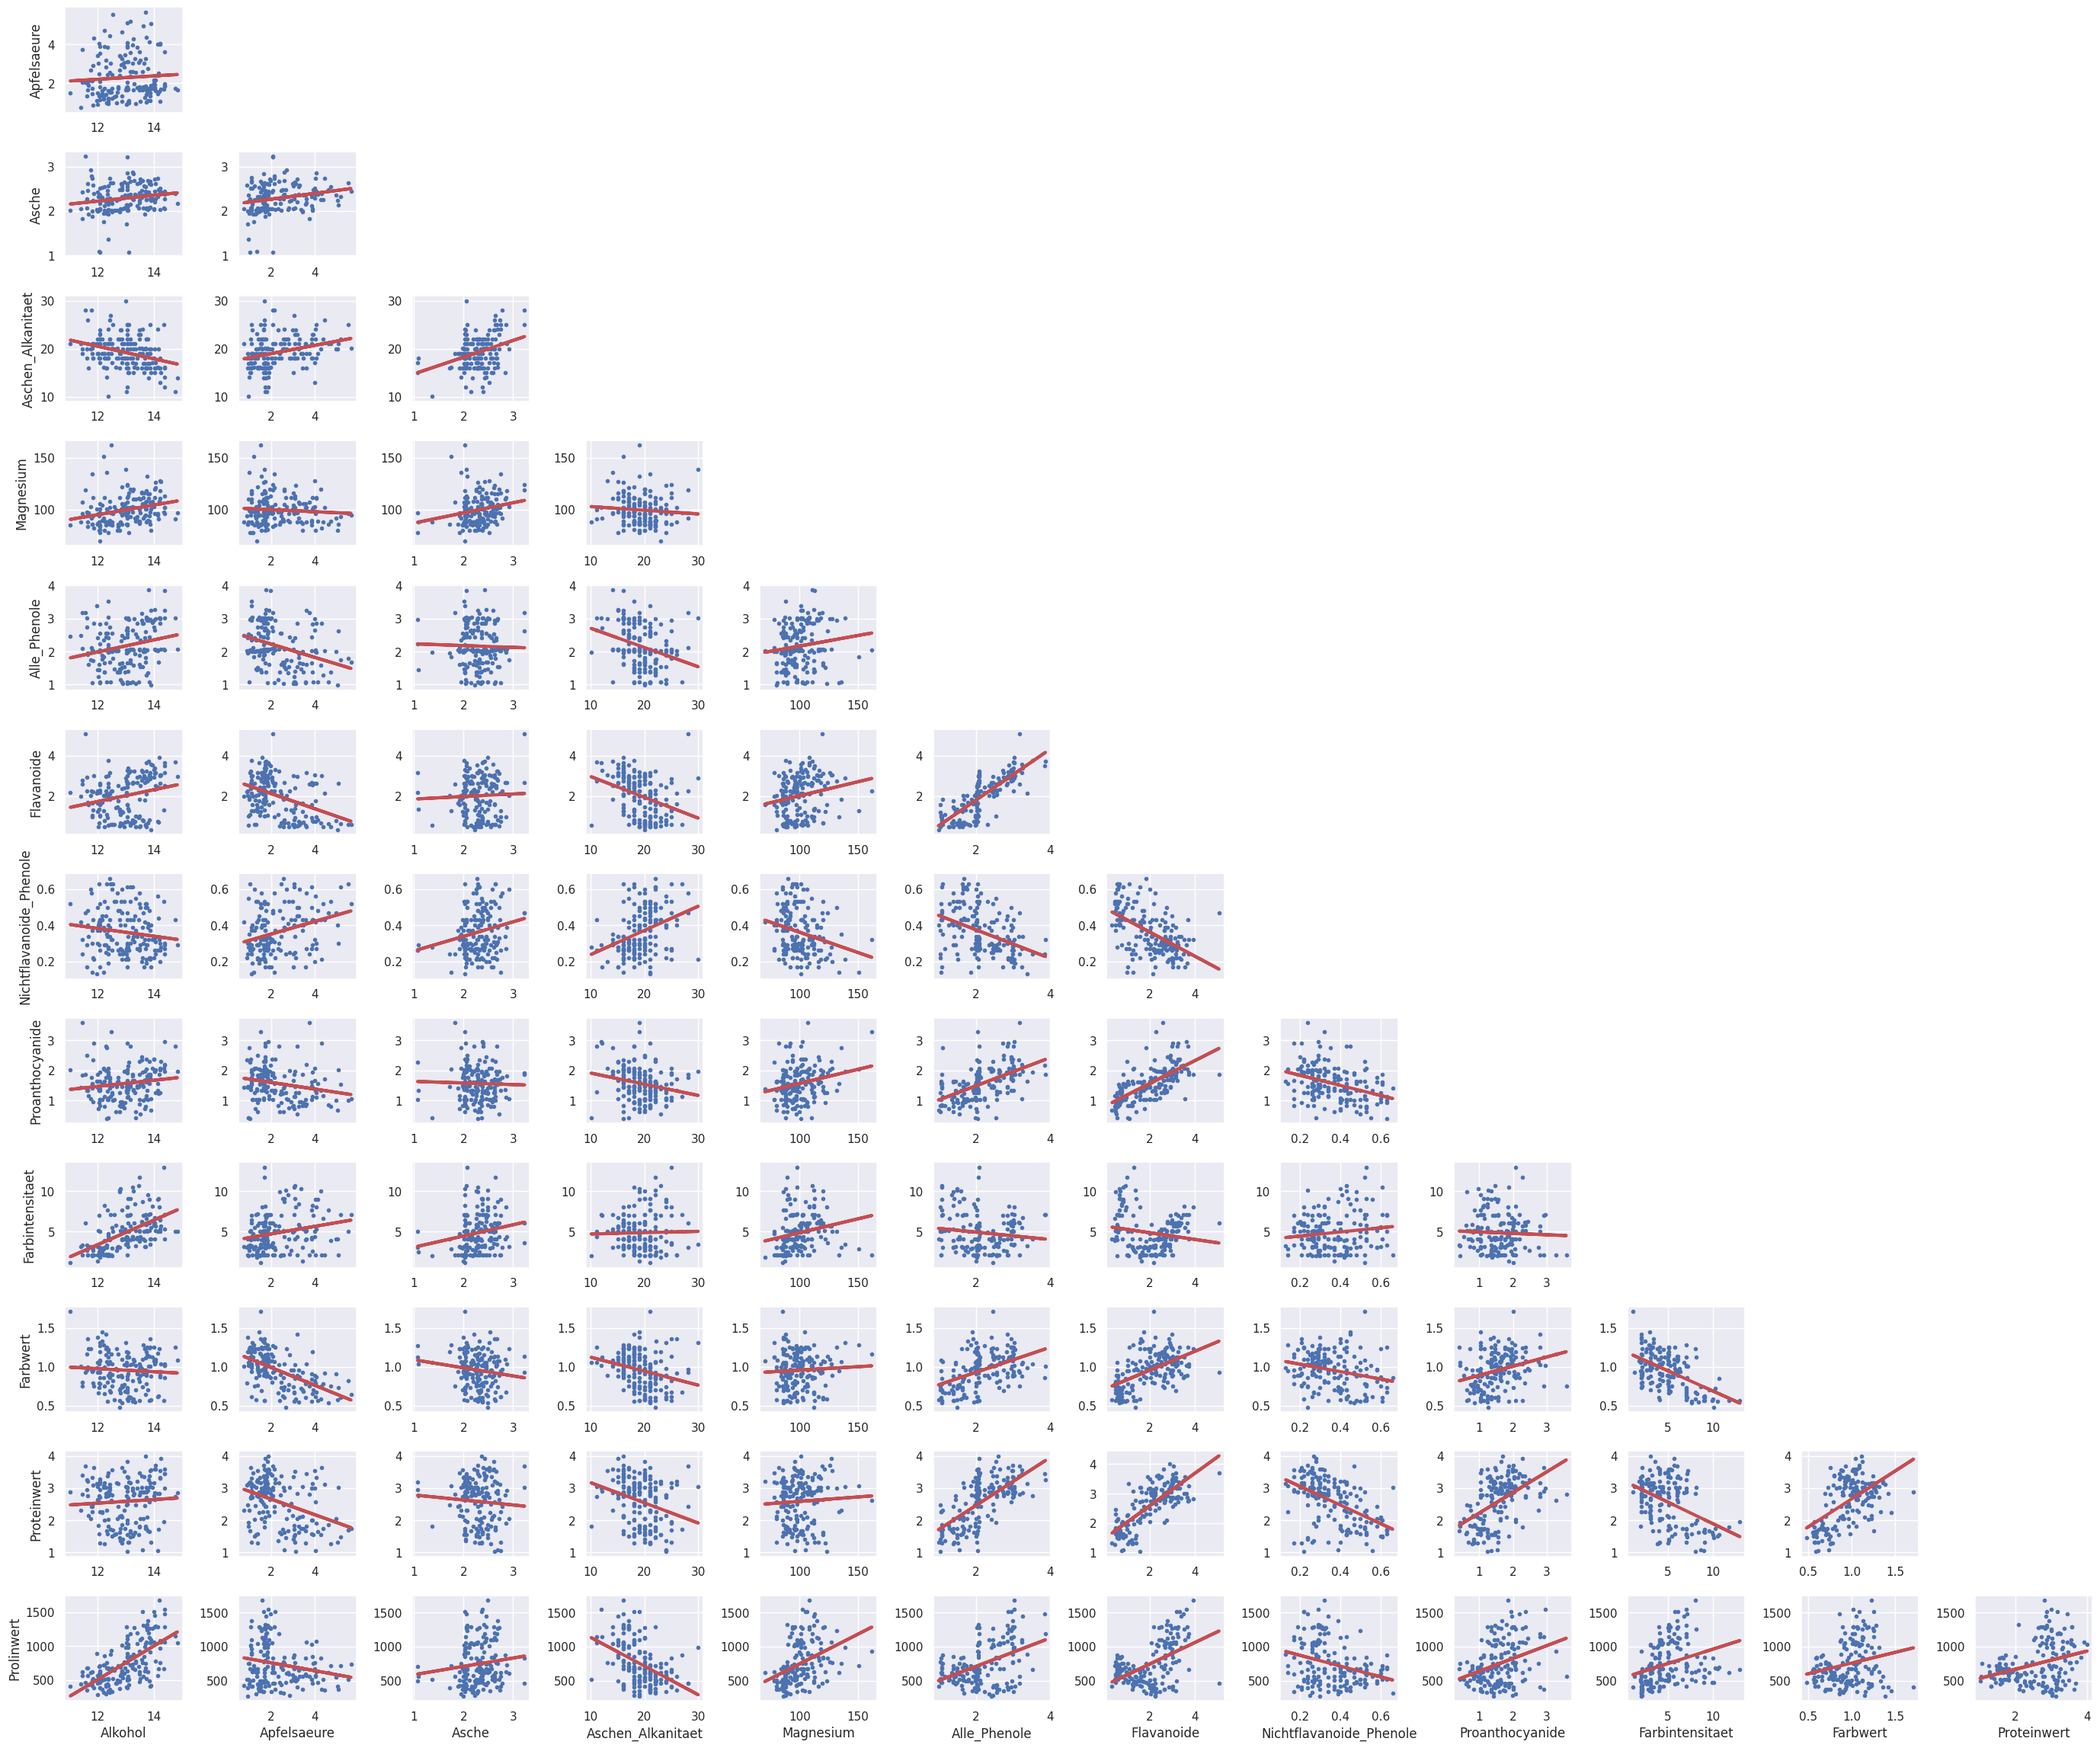

In [29]:
scores = {}
fig, axes = plt.subplots(nrows=len(df.columns), ncols=len(df.columns), figsize=(30, 25))

for i, col1 in enumerate(df.columns):
    for j, col2 in enumerate(df.columns):
        if i > j:
            X = np.array(df[col2])
            y = np.array(df[col1])
            X = np.reshape(X, (-1, 1))

            regr = LinearRegression()
            regr.fit(X, y)

            scores[(col2, col1)] = regr.score(X, y)

            axes[i, j].scatter(X, y, marker='.')
            axes[i, j].plot(X, regr.predict(X), 'r', linewidth=3)
            
            # Set labels only on the left and bottom edges
            if i == len(df.columns) - 1:
                axes[i, j].set_xlabel(col2)
            if j == 0:
                axes[i, j].set_ylabel(col1)
        else:
            # Hide the upper-right and diagonal subplots
            axes[i, j].set_visible(False)

plt.tight_layout()

plt.show()

We can take a look at the scores of each pairwise linear regression, which were calculating through the coefficient of determination $ R^2 $ during the loop. The best score is the one closest to 1.0.

In [30]:
scores

{('Alkohol', 'Apfelsaeure'): 0.003988373770667297,
 ('Alkohol', 'Asche'): 0.028112037177409843,
 ('Apfelsaeure', 'Asche'): 0.05088885380699859,
 ('Alkohol', 'Aschen_Alkanitaet'): 0.09948754727178832,
 ('Apfelsaeure', 'Aschen_Alkanitaet'): 0.08024032889680055,
 ('Asche', 'Aschen_Alkanitaet'): 0.10952139665161387,
 ('Alkohol', 'Magnesium'): 0.06990304700364602,
 ('Apfelsaeure', 'Magnesium'): 0.005628097014144351,
 ('Asche', 'Magnesium'): 0.04760015261219974,
 ('Aschen_Alkanitaet', 'Magnesium'): 0.0069663520488694175,
 ('Alkohol', 'Alle_Phenole'): 0.05177738971936052,
 ('Apfelsaeure', 'Alle_Phenole'): 0.11593200665244052,
 ('Asche', 'Alle_Phenole'): 0.0006932205438346939,
 ('Aschen_Alkanitaet', 'Alle_Phenole'): 0.09014376993802609,
 ('Magnesium', 'Alle_Phenole'): 0.019423698072510764,
 ('Alkohol', 'Flavanoide'): 0.05694240793654215,
 ('Apfelsaeure', 'Flavanoide'): 0.1731500393374107,
 ('Asche', 'Flavanoide'): 0.0015940612727874948,
 ('Aschen_Alkanitaet', 'Flavanoide'): 0.11995104434315296

We can retrieve the best linear regression pair and their $ R^2 $ score:

In [43]:
scores_values = [score for score in scores.values()]
print([{k: v} for k, v in scores.items() if v == max(scores_values)])

[{('Alle_Phenole', 'Flavanoide'): 0.6733509988219473}]


Alternatively, we can plot the rergressions in a simple one-liner using seaborn, though this doesn't allow us to retrieve the $ R^2 $ scores for evaluation:

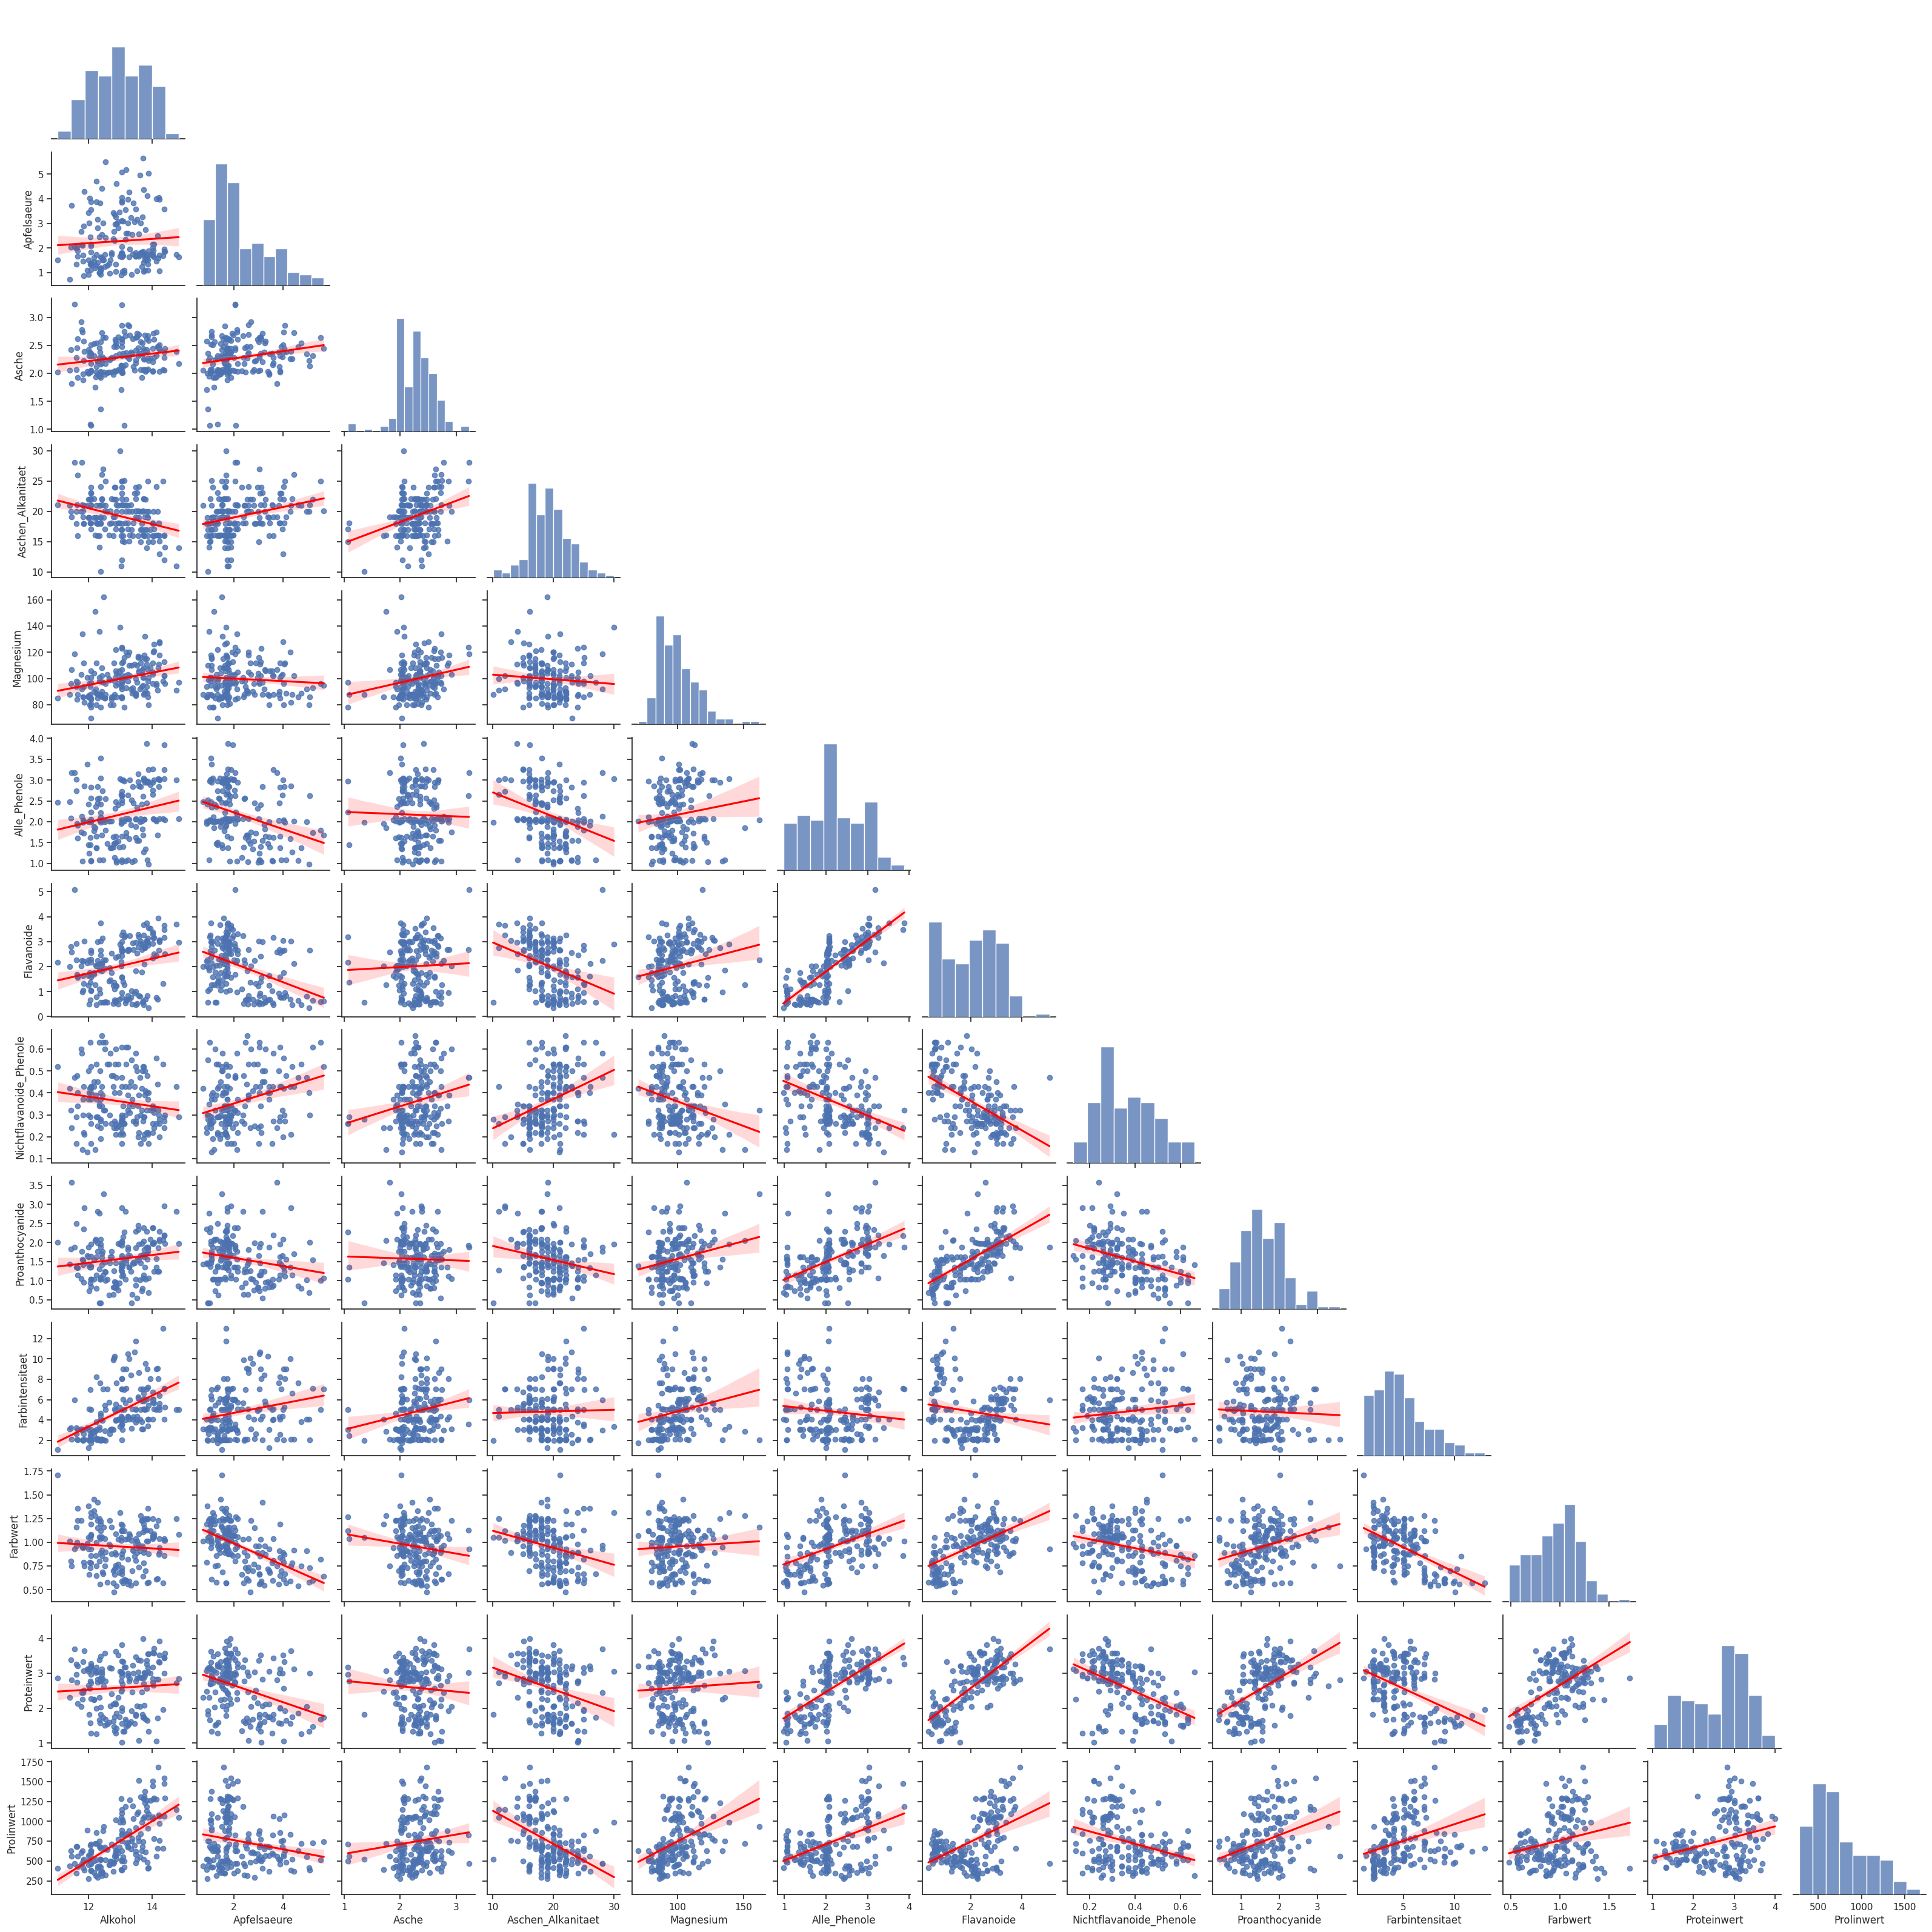

In [32]:
import seaborn as sns

sns.set(style='ticks', color_codes=True)
sns.pairplot(data=df, kind='reg', corner=True, plot_kws={'line_kws':{'color':'red'}})

### Clustering the data

We can use k-means to cluster the data and examine which amount of clusters is optimal. First, transform the dataframe to a numpy matrix:

In [33]:
X = df.to_numpy()
X

array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
        1.065e+03],
       [1.302e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.040e+00,
        1.050e+03],
       [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
        1.185e+03],
       ...,
       [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
        8.350e+02],
       [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
        8.400e+02],
       [1.413e+01, 4.010e+00, 2.740e+00, ..., 6.100e-01, 1.060e+00,
        5.600e+02]])

Calculate k-means with 2, 3, 4, and 5 clusters and record the corresponding Davies-Bouldin Indices and Silhouette Coefficients:

In [34]:
n_clusters = np.arange(2, 6)
db_scores = []
s_scores = []

for n in n_clusters:
    kmeans = KMeans(init='k-means++', n_init='auto', n_clusters=n, random_state=42)
    y_pred = kmeans.fit_predict(X)
    db_scores.append(davies_bouldin_score(X, y_pred))
    s_scores.append(silhouette_score(X, y_pred))

db_scores, s_scores

([0.47172520978383725,
  0.5318292934928265,
  0.5455811469441771,
  0.5062357297752802],
 [0.6628333087519137,
  0.5726202644206763,
  0.5665757077618224,
  0.5578893276834543])

Plot the Davies Bouldin Index and Silhouette Coefficients for each cluster amount:

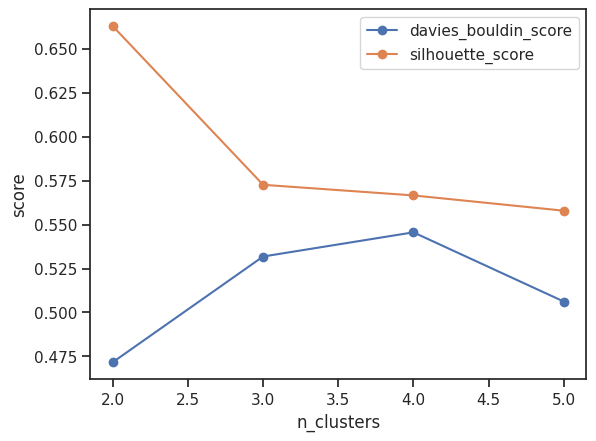

In [35]:
plt.plot(n_clusters, db_scores, 'o-')
plt.plot(n_clusters, s_scores, 'o-')
plt.xlabel('n_clusters')
plt.ylabel('score')
plt.legend(['davies_bouldin_score', 'silhouette_score'])
plt.show()

Determine the optimal number of clusters according to each score criteria: 

In [36]:
n_clusters[np.argmin(db_scores)], n_clusters[np.argmax(s_scores)]

(2, 2)

Since the two scores determined the same amount of clusters in this case, use the first one's optimum to initialize k-means

In [37]:
optimal_clusters = n_clusters[np.argmin(db_scores)]
optimal_kmeans = KMeans(init='k-means++', n_init='auto', n_clusters=optimal_clusters, random_state=42)

Take a look at the clusters by using PCA to transform the data and plot the points

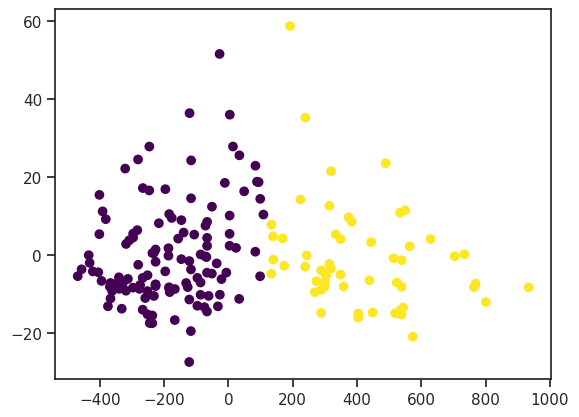

In [38]:
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=optimal_kmeans.fit_predict(X), cmap='viridis')
plt.show()

Create a scree plot for the components of our PCA on this dataset: 

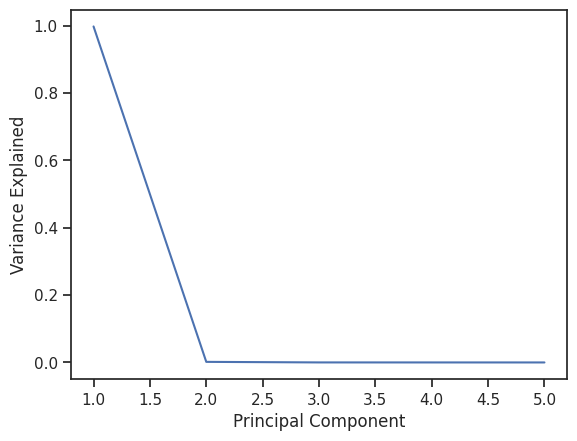

In [41]:
pca = PCA(n_components=5)
pca.fit(X)
pca_components = np.arange(pca.n_components_) + 1

plt.plot(pca_components, pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In this case, the first component seems to "explain" the data entirely while the second has an explained variance of zero. 

Not sure if this is correct but hey